### Load Model

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch
print(torch.cuda.current_device())  # Should print 0 (because only device 7 is visible)
print(torch.cuda.device_count())  # Should print 1 (only one device is available)


0
8


In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "/home/group/cad_codebased/llama_3.2/Llama_3.2_3B", # or choose "unsloth/Llama-3.2-1B-Instruct"
    model_name = "/home/group/cad_codebased/data/SFT_ckpt/ckpt_outputs_response/10500/ckpt_epoch1_30/checkpoint-21091",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/xiangyu/miniconda3/envs/cad_llm3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 8. Max memory: 23.558 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa9a9ad82b0>>
Traceback (most recent call last):
  File "/home/xiangyu/miniconda3/envs/cad_llm3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Unsloth 2025.3.18 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


### Add Lora Adapter

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)


Unsloth 2025.5.3 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


### Data Prep


In [4]:
use_rag = True  # Set to False if not using RAG


ABC_prompt_rag = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


### caption:
{}

### retrieved relevant step file:
{}

### output:
{}"""

ABC_prompt_no_rag = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description, generate a STEP file that accurately represents the described object.

### caption:
{}

### output:
{}"""

ABC_prompt_no_output = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description, generate a STEP file that accurately represents the described object.

### caption:
{}

### output:
"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["caption"]
    # inputs       = examples["relavant_step_file"]
    outputs      = examples["output"]
    # instructions = examples["instruction"]
    # inputs       = examples["input"]
    # outputs      = examples["output"]
    texts = []
    if use_rag:
        inputs = examples["relavant_step_file"]
        for instruction, input, output in zip(instructions, inputs, outputs):
            text = ABC_prompt_rag.format(instruction, input, output) + EOS_TOKEN
            texts.append(text)
    else:
        for instruction, output in zip(instructions, outputs):
            text = ABC_prompt_no_rag.format(instruction, output) + EOS_TOKEN
            texts.append(text)


    return { "text" : texts, }
pass

from datasets import load_dataset
# dataset = load_dataset("yahma/alpaca-cleaned", split = "train")

dataset = load_dataset(path="/home/group/cad_codebased/data/abc_rag/20500", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)
test_dataset = load_dataset(path="/home/group/cad_codebased/data/abc_rag/20500", split="test")
test_dataset = test_dataset.map(formatting_prompts_func, batched=True)


In [5]:
# Print the entire dataset
print(dataset)

# Print the first data entry
print(dataset[0]['text'])

Dataset({
    features: ['id_original', 'caption', 'id_retrieve', 'relavant_step_file', 'output', 'text'],
    num_rows: 14387
})
You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


### caption:
A long cylindrical rod with a small cylindrical section at one end.

### retrieved relevant step file:
DATA;
#1 = MECHANICAL_DESIGN_GEOMETRIC_PRESENTATION_REPRESENTATION( ' ', ( #10, #11, #12 ), #6 );
#2 = PRODUCT_DEFINITION_CONTEXT( '', #13, 'design' );
#3 = APPLICATION_PROTOCOL_DEFINITION( 'international standard', 'automotive_design', 2001, #13 );
#4 = PRODUCT_CATEGORY_RELATIONSHIP( 'NONE', 'NONE', #14, #15 );
#5 = SHAPE_DEFINITION_REPRESENTATION( #16, #17 );
#6 =  ( GEOMETRIC_REPRESENTATION_CONTEXT( 3 )GLOBAL_UNCERTAINTY_ASSIGNED_CONTEXT( ( #20 ) )GLOBAL_UNIT_ASSIGNED_CONTEXT( ( #22, #23, #24

### Train the Model

In [6]:
import wandb
wandb.login()  # paste your API key when prompted
wandb.init(
  project="cad_llm",    # this will be created under YOUR username by default
  # no need to pass `entity` if you want it under your personal account
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: 13567559686jason (13567559686jason-northwestern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

# trainer = SFTTrainer(
#     model = model,
#     tokenizer = tokenizer,
#     train_dataset = dataset,
#     dataset_text_field = "text",
#     max_seq_length = max_seq_length,
#     data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
#     dataset_num_proc = 2,
#     packing = False, # Can make training 5x faster for short sequences.
#     args = TrainingArguments(
#         per_device_train_batch_size = 2,
#         gradient_accumulation_steps = 4,
#         # warmup_steps = 110,
#         # num_train_epochs = 5, # Set this for 1 full training run.
#         max_steps = 10,
#         learning_rate = 2e-4,
#         fp16 = not is_bfloat16_supported(),
#         bf16 = is_bfloat16_supported(),
#         logging_steps = 5,
#         optim = "adamw_8bit",
#         weight_decay = 0.01,
#         lr_scheduler_type = "linear",
#         seed = 3407,
#         output_dir = "ckpt_outputs_response/ckpt_epoch11",
#         report_to = "none", # Use this for WandB etc
#     ),
# )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2, #4,
        warmup_steps = 1,#5,
        # warmup_steps = 3,
        # num_train_epochs = 1, # Set this for 1 full tranining run.
        # num_train_epochs = 2,
        max_steps = 10,#100,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/home/group/cad_codebased/data/SFT_ckpt/tmp_test_purpose",
        report_to = "none", # Use this for WandB etc
        # 关键改动:
        # report_to="wandb",              # 打开 wandb 报表
        # run_name="cad_sft_experiment",   # wandb 中的 run 名称
        save_strategy="epoch",          # 每个 epoch 保存一次模型
        # evaluation_strategy="steps",  # Run test loss calculation during training
        # eval_steps=12,  # Calculate test loss every 5 steps
        # remove_unused_columns=False,
    ),
)

In [8]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "### caption:\n",
    response_part = "### output:\n",
)

In [9]:
print(trainer.train_dataset)
print(trainer.eval_dataset)

Dataset({
    features: ['id_original', 'caption', 'id_retrieve', 'relavant_step_file', 'output', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14387
})
Dataset({
    features: ['id_original', 'caption', 'id_retrieve', 'relavant_step_file', 'output', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4110
})


In [10]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

"<|begin_of_text|>You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.\n\n\n### caption:\nA rectangular block with a sloped top surface.\n\n### retrieved relevant step file:\nDATA;\n#1 = MECHANICAL_DESIGN_GEOMETRIC_PRESENTATION_REPRESENTATION('', ( #10, #11, #12, #13, #14, #15 ), #6 );\n#2 = PRODUCT_DEFINITION_CONTEXT( '', #16, 'design' );\n#3 = APPLICATION_PROTOCOL_DEFINITION( 'international standard', 'automotive_design', 2001, #16 );\n#4 = PRODUCT_CATEGORY_RELATIONSHIP( 'NONE', 'NONE', #17, #18 );\n#5 = SHAPE_DEFINITION_REPRESENTATION( #19, #20 );\n#6 =  ( GEOMETRIC_REPRESENTATION_CONTEXT( 3 )GLOBAL_UNCERTAINTY_ASSIGNED_CONTEXT( ( #23 ) )GLOBAL_UNIT_ASSIGNED_CONTEXT( ( #25, #26, #27 ) )REPRESENTATION_CONTEXT( 'NONE', 'WORKSPACE' ) );\n#10 = STYLED_ITEM( '', ( #29 ), #30 );\n#11 = STYLED_

In [11]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [9]:
trainer_stats = trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 14,387 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 2 x 1) = 32
 "-____-"     Trainable parameters = 24,313,856/3,237,063,680 (0.75% trained)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 23.56 GiB of which 1.21 GiB is free. Process 2141604 has 408.00 MiB memory in use. Process 2593653 has 408.00 MiB memory in use. Process 2611543 has 408.00 MiB memory in use. Process 2759782 has 408.00 MiB memory in use. Process 3545010 has 3.55 GiB memory in use. Process 3551458 has 3.55 GiB memory in use. Including non-PyTorch memory, this process has 13.61 GiB memory in use. Of the allocated memory 13.16 GiB is allocated by PyTorch, and 191.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [35]:
import pandas as pd

stats_dict = {
    "epoch": [],
    "loss": [],
    "eval_loss": [],
    "learning_rate": [],
    "step": []
}

if hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
    last_eval_loss = None  # To keep track of the latest test loss
    for log in trainer.state.log_history:
        if "loss" in log:
            stats_dict["epoch"].append(log.get("epoch", "N/A"))
            stats_dict["loss"].append(log.get("loss", "N/A"))
            stats_dict["learning_rate"].append(log.get("learning_rate", "N/A"))
            stats_dict["step"].append(log.get("step", "N/A"))

            # Append last test loss available at this step
            stats_dict["eval_loss"].append(last_eval_loss)
        
        if "eval_loss" in log:
            last_eval_loss = log["eval_loss"]  # Update test loss when found

stats_df = pd.DataFrame(stats_dict)

print(stats_df)

      epoch    loss  eval_loss  learning_rate  step
0  0.005685  0.0894        NaN        0.00015     5
1  0.011370  0.0499        NaN        0.00010    10
2  0.017055  0.0618   0.132149        0.00005    15
3  0.022740  0.1156   0.132149        0.00000    20


### Inference


In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

In [5]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/home/group/cad_codebased/llama_3.2/Llama_3.2_3B", # or choose "unsloth/Llama-3.2-1B-Instruct"
    # model_name = "/home/group/cad_codebased/data/SFT_ckpt/ckpt_outputs_response/10500/ckpt_epoch1_30/checkpoint-21091",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 8. Max memory: 23.558 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.66s/it]


/home/group/cad_codebased/llama_3.2/Llama_3.2_3B does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


In [6]:
# alpaca_prompt = Copied from above
ABC_prompt = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


### caption:
{}

### retrieved relavant step file:
{}

### output:
{}"""

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    ABC_prompt.format(
        "A flat, elongated bar with multiple circular holes along its length", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 200, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.\n\n\n### caption:\nA flat, elongated bar with multiple circular holes along its length\n\n### retrieved relavant step file:\n\n\n### output:\nA STEP file (.step) that accurately represents the described object, including the flat, elongated bar with multiple circular holes along its length.\n\n### STEP file (.step) output:\n\n\n```STEP\nSTEP 7: Common\nFILE: Flat_Elongated_Bar_With_Holes.stp\nDATA: \n  1  (STEP Header)\n  2  (STEP File: Flat_Elongated_Bar_With_Holes.stp)\n  3  (STEP Header: Flat_Elongated_Bar_With_Holes.stp)\n  4  (STEP Header: Flat_Elongated_Bar_With_Holes.stp)\n  5  (STEP Header: Flat_Elongated_Bar_With_Holes.stp)\n  6  (STEP Header: Flat_Elongated_Bar_With_Holes.stp)\n  7  (STEP Header: Flat_Elongate

### Saving, loading finetuned models

In [17]:
model.save_pretrained("lora_model_response") # Local saving
tokenizer.save_pretrained("lora_model_response")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model_response/tokenizer_config.json',
 'lora_model_response/special_tokens_map.json',
 'lora_model_response/tokenizer.json')

In [ ]:
# Inference (RAG): /home/group/cad_codebased/data/SFT_ckpt/ckpt_outputs_response_rag/10500/ckpt_epoch1_30/checkpoint-25676
# restart all the kernels before running
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        #model_name = "lora_model_rag", # YOUR MODEL YOU USED FOR TRAINING
        model_name = "/home/group/cad_codebased/data/merged_model/dfs-7200",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

# ### Instruction:
# {}

# ### Input:
# {}

# ### Response:
# {}"""

# ABC_prompt = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


# ### caption:
# {}

# ### retrieved relavant step file:
# {}

# ### output:
# {}"""

ABC_prompt = """You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


### caption:
{}

### retrieved relavant step file:
{}

### output:
{}"""


inputs = tokenizer(
[
    ABC_prompt.format(
        "A rectangular block with a slanted top surface.", # instruction
        "DATA;\n#1 = MECHANICAL_DESIGN_GEOMETRIC_PRESENTATION_REPRESENTATION( ' ', ( #10, #11, #12, #13, #14, #15 ), #6 );\n#2 = PRODUCT_DEFINITION_CONTEXT( '', #16, 'design' );\n#3 = APPLICATION_PROTOCOL_DEFINITION( 'international standard', 'automotive_design', 2001, #16 );\n#4 = PRODUCT_CATEGORY_RELATIONSHIP( 'NONE', 'NONE', #17, #18 );\n#5 = SHAPE_DEFINITION_REPRESENTATION( #19, #20 );\n#6 =  ( GEOMETRIC_REPRESENTATION_CONTEXT( 3 )GLOBAL_UNCERTAINTY_ASSIGNED_CONTEXT( ( #23 ) )GLOBAL_UNIT_ASSIGNED_CONTEXT( ( #25, #26, #27 ) )REPRESENTATION_CONTEXT( 'NONE', 'WORKSPACE' ) );\n#10 = STYLED_ITEM( '', ( #29 ), #30 );\n#11 = STYLED_ITEM( '', ( #31 ), #32 );\n#12 = STYLED_ITEM( '', ( #33 ), #34 );\n#13 = STYLED_ITEM( '', ( #35 ), #36 );\n#14 = STYLED_ITEM( '', ( #37 ), #38 );\n#15 = STYLED_ITEM( '', ( #39 ), #40 );\n#16 = APPLICATION_CONTEXT( 'core data for automotive mechanical design processes' );\n#17 = PRODUCT_CATEGORY( 'part', 'NONE' );\n#18 = PRODUCT_RELATED_PRODUCT_CATEGORY( 'detail', ' ', ( #41 ) );\n#19 = PRODUCT_DEFINITION_SHAPE( 'NONE', 'NONE', #42 );\n#20 = ADVANCED_BREP_SHAPE_REPRESENTATION( 'Reference Geometry', ( #43, #44 ), #6 );\n#23 = UNCERTAINTY_MEASURE_WITH_UNIT( LENGTH_MEASURE( 1.00000000000000E-17 ), #25, '', '' );\n#25 =  ( CONVERSION_BASED_UNIT( 'METRE', #47 )LENGTH_UNIT(  )NAMED_UNIT( #50 ) );\n#26 =  ( NAMED_UNIT( #52 )PLANE_ANGLE_UNIT(  )SI_UNIT( $, .RADIAN. ) );\n#27 =  ( NAMED_UNIT( #52 )SI_UNIT( $, .STERADIAN. )SOLID_ANGLE_UNIT(  ) );\n#29 = PRESENTATION_STYLE_ASSIGNMENT( ( #58 ) );\n#30 = ADVANCED_FACE( '', ( #59 ), #60, .T. );\n#31 = PRESENTATION_STYLE_ASSIGNMENT( ( #61 ) );\n#32 = ADVANCED_FACE( '', ( #62 ), #63, .F. );\n#33 = PRESENTATION_STYLE_ASSIGNMENT( ( #64 ) );\n#34 = ADVANCED_FACE( '', ( #65 ), #66, .F. );\n#35 = PRESENTATION_STYLE_ASSIGNMENT( ( #67 ) );\n#36 = ADVANCED_FACE( '', ( #68 ), #69, .T. );\n#37 = PRESENTATION_STYLE_ASSIGNMENT( ( #70 ) );\n#38 = ADVANCED_FACE( '', ( #71 ), #72, .T. );\n#39 = PRESENTATION_STYLE_ASSIGNMENT( ( #73 ) );\n#40 = ADVANCED_FACE( '', ( #74 ), #75, .F. );\n#41 = PRODUCT( 'Reference Geometry', 'Reference Geometry', 'PART-Reference Geometry-DESC', ( #76 ) );\n#42 = PRODUCT_DEFINITION( 'NONE', 'NONE', #77, #2 );\n#43 = MANIFOLD_SOLID_BREP( 'Reference Geometry', #78 );\n#44 = AXIS2_PLACEMENT_3D( '', #79, #80, #81 );\n#47 = LENGTH_MEASURE_WITH_UNIT( LENGTH_MEASURE( 1.00000000000000 ), #82 );\n#50 = DIMENSIONAL_EXPONENTS( 1.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000 );\n#52 = DIMENSIONAL_EXPONENTS( 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000, 0.00000000000000 );\n#58 = SURFACE_STYLE_USAGE( .BOTH., #83 );\n#59 = FACE_OUTER_BOUND( '', #84, .T. );\n#60 = PLANE( '', #85 );\n#61 = SURFACE_STYLE_USAGE( .BOTH., #86 );\n#62 = FACE_OUTER_BOUND( '', #87, .T. );\n#63 = PLANE( '', #88 );\n#64 = SURFACE_STYLE_USAGE( .BOTH., #89 );\n#65 = FACE_OUTER_BOUND( '', #90, .T. );\n#66 = PLANE( '', #91 );\n#67 = SURFACE_STYLE_USAGE( .BOTH., #92 );\n#68 = FACE_OUTER_BOUND( '', #93, .T. );\n#69 = PLANE( '', #94 );\n#70 = SURFACE_STYLE_USAGE( .BOTH., #95 );\n#71 = FACE_OUTER_BOUND( '', #96, .T. );\n#72 = PLANE( '', #97 );\n#73 = SURFACE_STYLE_USAGE( .BOTH., #98 );\n#74 = FACE_OUTER_BOUND( '', #99, .T. );\n#75 = PLANE( '', #100 );\n#76 = PRODUCT_CONTEXT( '', #16, 'mechanical' );\n#77 = PRODUCT_DEFINITION_FORMATION_WITH_SPECIFIED_SOURCE( ' ', 'NONE', #41, .NOT_KNOWN. );\n#78 = CLOSED_SHELL( '', ( #38, #36, #34, #32, #40, #30 ) );\n#79 = CARTESIAN_POINT( '', ( 0.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#80 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#81 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#82 =  ( LENGTH_UNIT(  )NAMED_UNIT( #50 )SI_UNIT( $, .METRE. ) );\n#83 = SURFACE_SIDE_STYLE( '', ( #102 ) );\n#84 = EDGE_LOOP( '', ( #103, #104, #105, #106 ) );\n#85 = AXIS2_PLACEMENT_3D( '', #107, #108, #109 );\n#86 = SURFACE_SIDE_STYLE( '', ( #110 ) );\n#87 = EDGE_LOOP( '', ( #111, #112, #113, #114 ) );\n#88 = AXIS2_PLACEMENT_3D( '', #115, #116, #117 );\n#89 = SURFACE_SIDE_STYLE( '', ( #118 ) );\n#90 = EDGE_LOOP( '', ( #119, #120, #121, #122 ) );\n#91 = AXIS2_PLACEMENT_3D( '', #123, #124, #125 );\n#92 = SURFACE_SIDE_STYLE( '', ( #126 ) );\n#93 = EDGE_LOOP( '', ( #127, #128, #129, #130 ) );\n#94 = AXIS2_PLACEMENT_3D( '', #131, #132, #133 );\n#95 = SURFACE_SIDE_STYLE( '', ( #134 ) );\n#96 = EDGE_LOOP( '', ( #135, #136, #137, #138 ) );\n#97 = AXIS2_PLACEMENT_3D( '', #139, #140, #141 );\n#98 = SURFACE_SIDE_STYLE( '', ( #142 ) );\n#99 = EDGE_LOOP( '', ( #143, #144, #145, #146 ) );\n#100 = AXIS2_PLACEMENT_3D( '', #147, #148, #149 );\n#102 = SURFACE_STYLE_FILL_AREA( #150 );\n#103 = ORIENTED_EDGE( '', *, *, #151, .F. );\n#104 = ORIENTED_EDGE( '', *, *, #152, .F. );\n#105 = ORIENTED_EDGE( '', *, *, #153, .T. );\n#106 = ORIENTED_EDGE( '', *, *, #154, .T. );\n#107 = CARTESIAN_POINT( '', ( 0.00500000000000000, -0.0250000000000000, 0.00500000000000000 ) );\n#108 = DIRECTION( '', ( 0.00000000000000, -1.00000000000000, 0.00000000000000 ) );\n#109 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#110 = SURFACE_STYLE_FILL_AREA( #155 );\n#111 = ORIENTED_EDGE( '', *, *, #156, .T. );\n#112 = ORIENTED_EDGE( '', *, *, #157, .F. );\n#113 = ORIENTED_EDGE( '', *, *, #154, .F. );\n#114 = ORIENTED_EDGE( '', *, *, #158, .T. );\n#115 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.00646000046755786 ) );\n#116 = DIRECTION( '', ( -1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#117 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#118 = SURFACE_STYLE_FILL_AREA( #159 );\n#119 = ORIENTED_EDGE( '', *, *, #160, .T. );\n#120 = ORIENTED_EDGE( '', *, *, #158, .F. );\n#121 = ORIENTED_EDGE( '', *, *, #153, .F. );\n#122 = ORIENTED_EDGE( '', *, *, #161, .T. );\n#123 = CARTESIAN_POINT( '', ( 0.00500000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#124 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#125 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#126 = SURFACE_STYLE_FILL_AREA( #162 );\n#127 = ORIENTED_EDGE( '', *, *, #163, .F. );\n#128 = ORIENTED_EDGE( '', *, *, #161, .F. );\n#129 = ORIENTED_EDGE( '', *, *, #152, .T. );\n#130 = ORIENTED_EDGE( '', *, *, #164, .T. );\n#131 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.00646000046755786 ) );\n#132 = DIRECTION( '', ( -1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#133 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#134 = SURFACE_STYLE_FILL_AREA( #165 );\n#135 = ORIENTED_EDGE( '', *, *, #166, .F. );\n#136 = ORIENTED_EDGE( '', *, *, #164, .F. );\n#137 = ORIENTED_EDGE( '', *, *, #151, .T. );\n#138 = ORIENTED_EDGE( '', *, *, #157, .T. );\n#139 = CARTESIAN_POINT( '', ( 0.00500000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#140 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#141 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#142 = SURFACE_STYLE_FILL_AREA( #167 );\n#143 = ORIENTED_EDGE( '', *, *, #166, .T. );\n#144 = ORIENTED_EDGE( '', *, *, #156, .F. );\n#145 = ORIENTED_EDGE( '', *, *, #160, .F. );\n#146 = ORIENTED_EDGE( '', *, *, #163, .T. );\n#147 = CARTESIAN_POINT( '', ( 0.00500000000000000, 0.00000000000000, 0.00500000000000000 ) );\n#148 = DIRECTION( '', ( 0.00000000000000, -1.00000000000000, 0.00000000000000 ) );\n#149 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#150 = FILL_AREA_STYLE( '', ( #168 ) );\n#151 = EDGE_CURVE( '', #169, #170, #171, .T. );\n#152 = EDGE_CURVE( '', #172, #169, #173, .T. );\n#153 = EDGE_CURVE( '', #172, #174, #175, .T. );\n#154 = EDGE_CURVE( '', #174, #170, #176, .T. );\n#155 = FILL_AREA_STYLE( '', ( #177 ) );\n#156 = EDGE_CURVE( '', #178, #179, #180, .T. );\n#157 = EDGE_CURVE( '', #170, #179, #181, .T. );\n#158 = EDGE_CURVE( '', #174, #178, #182, .T. );\n#159 = FILL_AREA_STYLE( '', ( #183 ) );\n#160 = EDGE_CURVE( '', #184, #178, #185, .T. );\n#161 = EDGE_CURVE( '', #172, #184, #186, .T. );\n#162 = FILL_AREA_STYLE( '', ( #187 ) );\n#163 = EDGE_CURVE( '', #184, #188, #189, .T. );\n#164 = EDGE_CURVE( '', #169, #188, #190, .T. );\n#165 = FILL_AREA_STYLE( '', ( #191 ) );\n#166 = EDGE_CURVE( '', #188, #179, #192, .T. );\n#167 = FILL_AREA_STYLE( '', ( #193 ) );\n#168 = FILL_AREA_STYLE_COLOUR( '', #194 );\n#169 = VERTEX_POINT( '', #195 );\n#170 = VERTEX_POINT( '', #196 );\n#171 = LINE( '', #197, #198 );\n#172 = VERTEX_POINT( '', #199 );\n#173 = LINE( '', #200, #201 );\n#174 = VERTEX_POINT( '', #202 );\n#175 = LINE( '', #203, #204 );\n#176 = LINE( '', #205, #206 );\n#177 = FILL_AREA_STYLE_COLOUR( '', #207 );\n#178 = VERTEX_POINT( '', #208 );\n#179 = VERTEX_POINT( '', #209 );\n#180 = LINE( '', #210, #211 );\n#181 = LINE( '', #212, #213 );\n#182 = LINE( '', #214, #215 );\n#183 = FILL_AREA_STYLE_COLOUR( '', #216 );\n#184 = VERTEX_POINT( '', #217 );\n#185 = LINE( '', #218, #219 );\n#186 = LINE( '', #220, #221 );\n#187 = FILL_AREA_STYLE_COLOUR( '', #222 );\n#188 = VERTEX_POINT( '', #223 );\n#189 = LINE( '', #224, #225 );\n#190 = LINE( '', #226, #227 );\n#191 = FILL_AREA_STYLE_COLOUR( '', #228 );\n#192 = LINE( '', #229, #230 );\n#193 = FILL_AREA_STYLE_COLOUR( '', #231 );\n#194 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#195 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#196 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#197 = CARTESIAN_POINT( '', ( 0.00500000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#198 = VECTOR( '', #232, 1.00000000000000 );\n#199 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#200 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.00646000046755786 ) );\n#201 = VECTOR( '', #233, 1.00000000000000 );\n#202 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#203 = CARTESIAN_POINT( '', ( 0.00500000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#204 = VECTOR( '', #234, 1.00000000000000 );\n#205 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.00646000046755786 ) );\n#206 = VECTOR( '', #235, 1.00000000000000 );\n#207 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#208 = CARTESIAN_POINT( '', ( 0.0100000000000000, 0.00000000000000, 0.00000000000000 ) );\n#209 = CARTESIAN_POINT( '', ( 0.0100000000000000, 0.00000000000000, 0.0100000000000000 ) );\n#210 = CARTESIAN_POINT( '', ( 0.0100000000000000, 0.00000000000000, 0.00646000046755786 ) );\n#211 = VECTOR( '', #236, 1.00000000000000 );\n#212 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#213 = VECTOR( '', #237, 1.00000000000000 );\n#214 = CARTESIAN_POINT( '', ( 0.0100000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#215 = VECTOR( '', #238, 1.00000000000000 );\n#216 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#217 = CARTESIAN_POINT( '', ( 0.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#218 = CARTESIAN_POINT( '', ( 0.00500000000000000, 0.00000000000000, 0.00000000000000 ) );\n#219 = VECTOR( '', #239, 1.00000000000000 );\n#220 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.00000000000000 ) );\n#221 = VECTOR( '', #240, 1.00000000000000 );\n#222 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#223 = CARTESIAN_POINT( '', ( 0.00000000000000, 0.00000000000000, 0.0100000000000000 ) );\n#224 = CARTESIAN_POINT( '', ( 0.00000000000000, 0.00000000000000, 0.00646000046755786 ) );\n#225 = VECTOR( '', #241, 1.00000000000000 );\n#226 = CARTESIAN_POINT( '', ( 0.00000000000000, -0.0250000000000000, 0.0100000000000000 ) );\n#227 = VECTOR( '', #242, 1.00000000000000 );\n#228 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#229 = CARTESIAN_POINT( '', ( 0.00500000000000000, 0.00000000000000, 0.0100000000000000 ) );\n#230 = VECTOR( '', #243, 1.00000000000000 );\n#231 = COLOUR_RGB( '', 0.603921592200000, 0.647058844600000, 0.686274528500000 );\n#232 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#233 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#234 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#235 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#236 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#237 = DIRECTION( '', ( 0.00000000000000, 1.00000000000000, 0.00000000000000 ) );\n#238 = DIRECTION( '', ( 0.00000000000000, 1.00000000000000, 0.00000000000000 ) );\n#239 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\n#240 = DIRECTION( '', ( 0.00000000000000, 1.00000000000000, 0.00000000000000 ) );\n#241 = DIRECTION( '', ( 0.00000000000000, 0.00000000000000, 1.00000000000000 ) );\n#242 = DIRECTION( '', ( 0.00000000000000, 1.00000000000000, 0.00000000000000 ) );\n#243 = DIRECTION( '', ( 1.00000000000000, 0.00000000000000, 0.00000000000000 ) );\nENDSEC;\nEND-ISO-10303-21;",
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2000)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 8. Max memory: 23.558 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


/home/group/cad_codebased/llama_3.2/Llama_3.2_3B does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.
<|begin_of_text|>You are a CAD model generation assistant trained to produce STEP (.step) files based on textual descriptions. Given the following object description and relevant retrieved CAD data, generate a STEP file that accurately represents the described object.


### caption:
A rectangular block with a slanted top surface.

### retrieved relavant step file:
DATA;
#1 = MECHANICAL_DESIGN_GEOMETRIC_PRESENTATION_REPRESENTATION('', ( #10, #11, #12, #13, #14, #15 ), #6 );
#2 = PRODUCT_DEFINITION_CONTEXT( '', #16, 'design' );
#3 = APPLICATION_PROTOCOL_DEFINITION( 'international standard', 'automotive_design', 2001, #16 );
#4 = PRODUCT_CATEGORY_RELATIONSHIP( 'NONE', 'NONE', #17, #18 );
#5 = SHAPE_DEFINITION_REPRESENTATION( #19, #20 );
#6 =  ( GEOMETRIC_REPRESENTATION_CONTEXT( 3 )GLOBAL_UNCERTAINTY_ASSIGNED_CONTEXT( ( #23 ) )GLOBAL_UNIT_ASSIGNED_CONTEXT( ( #25, 

KeyboardInterrupt: 

### Plot loss

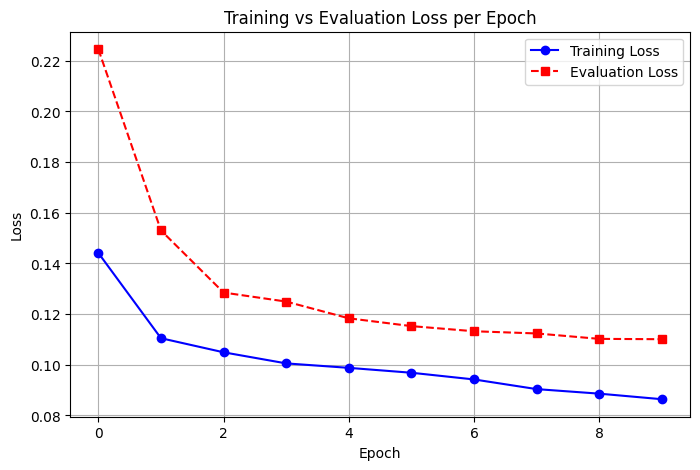

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
train_csv_file = "/home/group/cad_codebased/training_log/training_stats_3500_epoch10.csv"
df_train = pd.read_csv(train_csv_file)

eval_csv_file = "/home/group/cad_codebased/training_log/eval_stats_3500_epoch10.csv"
df_eval = pd.read_csv(eval_csv_file)

# Compute average loss per epoch
epochs_train = df_train["epoch"]
losses_train = df_train["loss"]

# Create a dictionary to store sum and count of losses for each epoch
epoch_loss_train = {}
for epoch, loss in zip(epochs_train, losses_train):
    rounded_epoch = int(epoch)  # Convert fractional epoch to integer epoch number
    if rounded_epoch not in epoch_loss_train:
        epoch_loss_train[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train[rounded_epoch]["sum"] += loss
    epoch_loss_train[rounded_epoch]["count"] += 1

# Compute average loss for each epoch
epoch_avg_loss_train = {epoch: epoch_loss_train[epoch]["sum"] / epoch_loss_train[epoch]["count"] for epoch in epoch_loss_train}

# Compute average evaluation loss per epoch
epochs_eval = df_eval["epoch"]
losses_eval = df_eval["eval_loss"]

# Dictionary to store sum and count of evaluation losses per epoch
epoch_loss_eval = {}
for epoch, loss in zip(epochs_eval, losses_eval):
    rounded_epoch = int(epoch)  # Convert fractional epoch to integer epoch number
    if rounded_epoch not in epoch_loss_eval:
        epoch_loss_eval[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_eval[rounded_epoch]["sum"] += loss
    epoch_loss_eval[rounded_epoch]["count"] += 1

# Compute average evaluation loss per epoch
epoch_avg_loss_eval = {epoch: epoch_loss_eval[epoch]["sum"] / epoch_loss_eval[epoch]["count"] for epoch in epoch_loss_eval}

# Plot training and evaluation loss curves
plt.figure(figsize=(8, 5))
plt.plot(epoch_avg_loss_train.keys(), epoch_avg_loss_train.values(), marker="o", linestyle="-", label="Training Loss", color="blue")
plt.plot(epoch_avg_loss_eval.keys(), epoch_avg_loss_eval.values(), marker="s", linestyle="--", label="Evaluation Loss", color="red")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss per Epoch")
plt.legend()
plt.grid()

# Show the plot
plt.show()

{1: 0.1441451428571429, 2: 0.11048011363636362, 3: 0.10491250000000009, 4: 0.10053352272727273, 5: 0.09877159090909089, 6: 0.09683806818181818, 7: 0.09419375000000003, 8: 0.090375, 9: 0.08858238636363638, 10: 0.08638685714285715}
{1: 0.1441451428571429, 2: 0.11048011363636362, 3: 0.10491250000000009, 4: 0.10053352272727273, 5: 0.09877159090909089, 6: 0.09683806818181818, 7: 0.09419375000000003, 8: 0.090375, 9: 0.08858238636363638, 10: 0.08638685714285715, 11: 0.0873875, 12: 0.0885, 13: 0.08846666666666667, 14: 0.08551111111111112, 15: 0.08648750000000001, 16: 0.0848, 17: 0.08442222222222223, 18: 0.08198888888888889, 19: 0.08281111111111111, 20: 0.08258750000000001, 21: 0.08025, 22: 0.08093333333333334, 23: 0.08126666666666667, 24: 0.07906666666666667, 25: 0.0803375, 26: 0.07745, 27: 0.07844444444444444, 28: 0.07733333333333332, 29: 0.0753111111111111, 30: 0.076625}


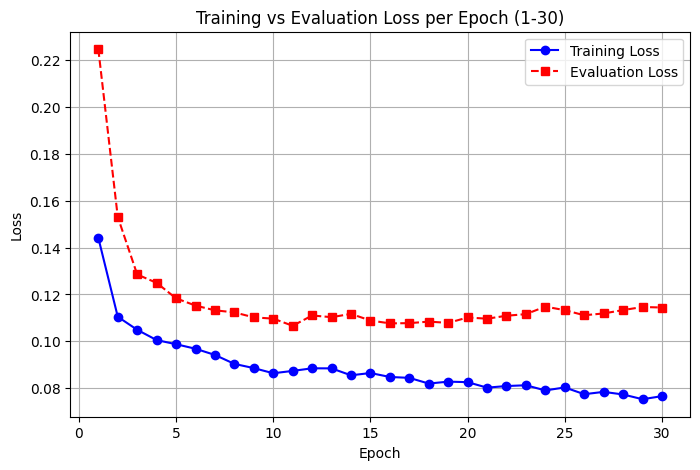

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
train_csv_1_10 = "/home/group/cad_codebased/training_log/training_stats_3500_epoch10.csv"
train_csv_11_20 = "/home/group/cad_codebased/training_log/training_stats_3500_epoch11_20.csv"
train_csv_21_25 = "/home/group/cad_codebased/training_log/training_stats_3500_epoch21_25.csv"
train_csv_26_30 = "/home/group/cad_codebased/training_log/training_stats_3500_epoch26_30.csv"
eval_csv = "/home/group/cad_codebased/training_log/eval_loss_ckpt.csv"

# Load training loss for epochs 1-10
df_train_1_10 = pd.read_csv(train_csv_1_10)
epochs_train_1_10 = df_train_1_10["epoch"]
losses_train_1_10 = df_train_1_10["loss"]

# Compute average training loss per epoch (1-10)
epoch_loss_train_1_10 = {}
for epoch, loss in zip(epochs_train_1_10, losses_train_1_10):
    rounded_epoch = int(epoch)+1  
    if rounded_epoch not in epoch_loss_train_1_10:
        epoch_loss_train_1_10[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train_1_10[rounded_epoch]["sum"] += loss
    epoch_loss_train_1_10[rounded_epoch]["count"] += 1

epoch_avg_loss_train_1_10 = {
    epoch: epoch_loss_train_1_10[epoch]["sum"] / epoch_loss_train_1_10[epoch]["count"]
    for epoch in epoch_loss_train_1_10
}
print(epoch_avg_loss_train_1_10)

# Load training loss for epochs 11-20
df_train_11_20 = pd.read_csv(train_csv_11_20)
epochs_train_11_20 = df_train_11_20["epoch"]
losses_train_11_20 = df_train_11_20["loss"]

# Compute average training loss per epoch (11-20)
epoch_loss_train_11_20 = {}
for epoch, loss in zip(epochs_train_11_20, losses_train_11_20):
    rounded_epoch = int(epoch) + 11  
    if rounded_epoch not in epoch_loss_train_11_20:
        epoch_loss_train_11_20[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train_11_20[rounded_epoch]["sum"] += loss
    epoch_loss_train_11_20[rounded_epoch]["count"] += 1

epoch_avg_loss_train_11_20 = {
    epoch: epoch_loss_train_11_20[epoch]["sum"] / epoch_loss_train_11_20[epoch]["count"]
    for epoch in epoch_loss_train_11_20
}

# Load training loss for epochs 21-25
df_train_21_25 = pd.read_csv(train_csv_21_25)
epochs_train_21_25 = df_train_21_25["epoch"]
losses_train_21_25 = df_train_21_25["loss"]

# Compute average training loss per epoch (11-20)
epoch_loss_train_21_25 = {}
for epoch, loss in zip(epochs_train_21_25, losses_train_21_25):
    rounded_epoch = int(epoch) + 21  
    if rounded_epoch not in epoch_loss_train_21_25:
        epoch_loss_train_21_25[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train_21_25[rounded_epoch]["sum"] += loss
    epoch_loss_train_21_25[rounded_epoch]["count"] += 1

epoch_avg_loss_train_21_25 = {
    epoch: epoch_loss_train_21_25[epoch]["sum"] / epoch_loss_train_21_25[epoch]["count"]
    for epoch in epoch_loss_train_21_25
}

# Load training loss for epochs 26-30
df_train_26_30 = pd.read_csv(train_csv_26_30)
epochs_train_26_30 = df_train_26_30["epoch"]
losses_train_26_30 = df_train_26_30["loss"]

# Compute average training loss per epoch (11-20)
epoch_loss_train_26_30 = {}
for epoch, loss in zip(epochs_train_26_30, losses_train_26_30):
    rounded_epoch = int(epoch) + 26  
    if rounded_epoch not in epoch_loss_train_26_30:
        epoch_loss_train_26_30[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train_26_30[rounded_epoch]["sum"] += loss
    epoch_loss_train_26_30[rounded_epoch]["count"] += 1

epoch_avg_loss_train_26_30 = {
    epoch: epoch_loss_train_26_30[epoch]["sum"] / epoch_loss_train_26_30[epoch]["count"]
    for epoch in epoch_loss_train_26_30
}
# print(epoch_avg_loss_train_11_20)
# Merge training losses from epochs 1-20
epoch_avg_loss_train = {**epoch_avg_loss_train_1_10, **epoch_avg_loss_train_11_20, **epoch_avg_loss_train_21_25, **epoch_avg_loss_train_26_30}
print(epoch_avg_loss_train)

# Load evaluation loss for epochs 1-20
df_eval = pd.read_csv(eval_csv)
epochs_eval = df_eval["epoch"]
losses_eval = df_eval["eval_loss"]

# Compute average evaluation loss per epoch (1-20)
epoch_loss_eval = {}
for epoch, loss in zip(epochs_eval, losses_eval):
    rounded_epoch = int(epoch)  
    if rounded_epoch not in epoch_loss_eval:
        epoch_loss_eval[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_eval[rounded_epoch]["sum"] += loss
    epoch_loss_eval[rounded_epoch]["count"] += 1

epoch_avg_loss_eval = {
    epoch: epoch_loss_eval[epoch]["sum"] / epoch_loss_eval[epoch]["count"]
    for epoch in epoch_loss_eval
}

# Plot training and evaluation loss curves
plt.figure(figsize=(8, 5))
plt.plot(epoch_avg_loss_train.keys(), epoch_avg_loss_train.values(), marker="o", linestyle="-", label="Training Loss", color="blue")
plt.plot(epoch_avg_loss_eval.keys(), epoch_avg_loss_eval.values(), marker="s", linestyle="--", label="Evaluation Loss", color="red")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss per Epoch (1-30)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In the above figure, epoch1-10 and epoch11-20 are trained separately, with lr strategy being set "linear" and "constant" namely. (epoch1-10: 2e-4 -> 0, epoch11-20: 2e-05)

{1: 0.3600555555555556, 2: 0.11794444444444444, 3: 0.10476666666666665, 4: 0.09876666666666667, 5: 0.09586666666666666, 6: 0.0943888888888889, 7: 0.09245999999999999, 8: 0.09118888888888889, 9: 0.08847777777777778, 10: 0.08886666666666668, 11: 0.0873111111111111, 12: 0.08663000000000001, 13: 0.0856, 14: 0.08493333333333333, 15: 0.08294444444444445, 16: 0.08471111111111113, 17: 0.08075555555555555, 18: 0.08095000000000001, 19: 0.08034444444444445, 20: 0.07967777777777779, 21: 0.07787777777777777, 22: 0.07711111111111112, 23: 0.07701111111111111, 24: 0.07591, 25: 0.07528888888888889, 26: 0.0738111111111111, 27: 0.07402222222222223, 28: 0.07218888888888889, 29: 0.07292222222222221, 30: 0.07108, 31: 0.07013333333333333, 32: 0.06884444444444444, 33: 0.06977777777777777, 34: 0.06832222222222223, 35: 0.06767777777777778, 36: 0.06689999999999999, 37: 0.06691111111111112, 38: 0.06708888888888889, 39: 0.06609999999999999, 40: 0.06570000000000001}


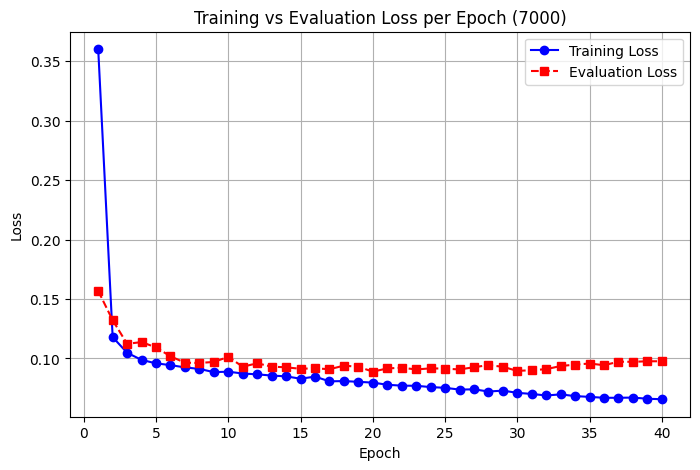

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
train_csv = "/home/group/cad_codebased/training_log/training_stats_7000_epoch40_rag.csv"
eval_csv = "/home/group/cad_codebased/training_log/eval_loss_7000_epoch_rag.csv"

# Load training loss for epochs 1-10
df_train = pd.read_csv(train_csv)
epochs_train = df_train["epoch"]
losses_train = df_train["loss"]

# Compute average training loss per epoch (1-10)
epoch_loss_train = {}
for epoch, loss in zip(epochs_train, losses_train):
    rounded_epoch = int(epoch)+1  
    if rounded_epoch not in epoch_loss_train:
        epoch_loss_train[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_train[rounded_epoch]["sum"] += loss
    epoch_loss_train[rounded_epoch]["count"] += 1

epoch_avg_loss_train = {
    epoch: epoch_loss_train[epoch]["sum"] / epoch_loss_train[epoch]["count"]
    for epoch in epoch_loss_train
}
print(epoch_avg_loss_train)




# Load evaluation loss for epochs 1-20
df_eval = pd.read_csv(eval_csv)
epochs_eval = df_eval["epoch"]
losses_eval = df_eval["eval_loss"]

# Compute average evaluation loss per epoch (1-20)
epoch_loss_eval = {}
for epoch, loss in zip(epochs_eval, losses_eval):
    rounded_epoch = int(epoch)  
    if rounded_epoch not in epoch_loss_eval:
        epoch_loss_eval[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_eval[rounded_epoch]["sum"] += loss
    epoch_loss_eval[rounded_epoch]["count"] += 1

epoch_avg_loss_eval = {
    epoch: epoch_loss_eval[epoch]["sum"] / epoch_loss_eval[epoch]["count"]
    for epoch in epoch_loss_eval
}

# Plot training and evaluation loss curves
plt.figure(figsize=(8, 5))
plt.plot(epoch_avg_loss_train.keys(), epoch_avg_loss_train.values(), marker="o", linestyle="-", label="Training Loss", color="blue")
plt.plot(epoch_avg_loss_eval.keys(), epoch_avg_loss_eval.values(), marker="s", linestyle="--", label="Evaluation Loss", color="red")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss per Epoch (7000)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [3]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# train_csv_file = "/home/group/cad_codebased/training_log/training_stats_3500_epoch10.csv"
# df_train = pd.read_csv(train_csv_file)

eval_csv_file = "/home/group/cad_codebased/training_log/eval_stats_3500_epoch10.csv"
df_eval = pd.read_csv(eval_csv_file)

# Compute average loss per epoch
# epochs_train = df_train["epoch"]
# losses_train = df_train["loss"]

# Create a dictionary to store sum and count of losses for each epoch
# epoch_loss_train = {}
# for epoch, loss in zip(epochs_train, losses_train):
#     rounded_epoch = int(epoch)  # Convert fractional epoch to integer epoch number
#     if rounded_epoch not in epoch_loss_train:
#         epoch_loss_train[rounded_epoch] = {"sum": 0, "count": 0}
#     epoch_loss_train[rounded_epoch]["sum"] += loss
#     epoch_loss_train[rounded_epoch]["count"] += 1

# Compute average loss for each epoch
# epoch_avg_loss_train = {epoch: epoch_loss_train[epoch]["sum"] / epoch_loss_train[epoch]["count"] for epoch in epoch_loss_train}

# Compute average evaluation loss per epoch
epochs_eval = df_eval["epoch"]
losses_eval = df_eval["eval_loss"]

# Dictionary to store sum and count of evaluation losses per epoch
epoch_loss_eval = {}
for epoch, loss in zip(epochs_eval, losses_eval):
    rounded_epoch = int(epoch)  # Convert fractional epoch to integer epoch number
    if rounded_epoch not in epoch_loss_eval:
        epoch_loss_eval[rounded_epoch] = {"sum": 0, "count": 0}
    epoch_loss_eval[rounded_epoch]["sum"] += loss
    epoch_loss_eval[rounded_epoch]["count"] += 1

# Compute average evaluation loss per epoch
epoch_avg_loss_eval = {epoch: epoch_loss_eval[epoch]["sum"] / epoch_loss_eval[epoch]["count"] for epoch in epoch_loss_eval}

for epoch, avg_loss in epoch_avg_loss_eval.items():
    print(f"Epoch: {epoch}, Average Evaluation Loss: {avg_loss}")

    # Append the results to the CSV file
    results_df = pd.DataFrame({"epoch": [epoch], "eval_loss": [avg_loss]})
    results_df.to_csv("/home/group/cad_codebased/training_log/eval_loss_ckpt.csv", mode='a', header=False, index=False)

Epoch: 0, Average Evaluation Loss: 0.22458481613327475
Epoch: 1, Average Evaluation Loss: 0.1530381225877338
Epoch: 2, Average Evaluation Loss: 0.12850554813356957
Epoch: 3, Average Evaluation Loss: 0.1249378625717428
Epoch: 4, Average Evaluation Loss: 0.11833545258816548
Epoch: 5, Average Evaluation Loss: 0.11525156307551593
Epoch: 6, Average Evaluation Loss: 0.11322421621945167
Epoch: 7, Average Evaluation Loss: 0.11235477731508366
Epoch: 8, Average Evaluation Loss: 0.11021695451603992
Epoch: 9, Average Evaluation Loss: 0.11008302867412564
